# Übungsblatt 2 - Programmieraufgaben (15 Punkte)
Einführung in Deep Learning für Visual Computing

**Deadline - 06.05.2025, 14:00 via Stud.IP (VIPS)**



## Imports und Visualisierung

Zur Visualisierung verwenden wir hier [Matplotlib](https://matplotlib.org/). Da wir bisher nur PyTorch und Jupyter in der Conda Kursumgebung installiert haben, muss die Matplotlib noch installiert werden. Dies sollte automatisch beim ersten Ausführen der nächsten Zelle passieren. Es kann notwendig sein Jupyter oder die IDE ihrer Wahl neu zu starten damit die Installation richtig erkannt wird.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import math
from typing import Callable

try:
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    # Matplotlib ist noch nicht installiert in der aktuellen Umgebung und
    # wird mit Hilfe von conda installiert. Dies kann einen Moment dauern.
    import sys

    %conda install --yes --prefix {sys.prefix} matplotlib
    import matplotlib.pyplot as plt

from visualization import (
    create_contourline_figure,
    scatter_path_in_figure,
    create_losscurve_figure,
    create_trapezoid_figure,
    scatter_points_and_labels,
    show_figure,
)

Damit wir uns um die Details der Visualisierung so wenig Gedanken wie nötig machen müssen haben wir die folgenden Funktion gegeben:

 * ```create_contourline_figure(fn : Callable, log_scale : bool)``` erzeugt eine Konturlinienfigur für eine gegebene Funktion fn. Die Funktion fn muss einen Tensor der Form $(n,2)$ akzeptieren und einen Tensor der Form $(n,)$ mit Skalarwerten zurückgeben. Die Option log_scale bestimmt, ob die Z-Achse logarithmisch skaliert werden soll oder nicht. Die Funktion gibt ein matplotlib.pyplot.Figure-Objekt zurück, das die Konturlinienfigur enthält.

 * ```scatter_path_in_figure(fig : plt.Figure, path : torch.Tensor, name : str)``` nimmt eine plt.Figure-Instanz, einen Pfad als torch.Tensor und einen Namen als String als Parameter entgegen und gibt eine plt.Figure-Instanz zurück. Die Funktion zeichnet den Pfad als Scatterplot in die übergebene Figur ein und beschriftet ihn mit dem Namen. Die Funktion ist nützlich, um mehrere Pfade in einer einzigen Figur zu vergleichen.

 * ```create_losscurve_figure(loss_values : list[float])``` erstellt eine Grafik, die den Verlustwert (loss value) in Abhängigkeit von der Anzahl der Trainingsiterationen zeigt. Die Funktion nimmt eine Liste von Gleitkommazahlen als Eingabe, die die Verlustwerte für jede Iteration enthalten. Die Funktion gibt ein plt.Figure-Objekt zurück, das die Grafik darstellt.

 * ```create_trapezoid_figure(q1: tuple[int], q2: tuple[int], q3: tuple[int], q4: tuple[int])``` erstellt ein Plot eines Trapezes, das durch vier Punkte definiert ist. Sie nimmt die Koordinaten dieser vier Punkte als Eingabe und gibt die entsprechende matplotlib Figure-Instanz zurück.

 * ```scatter_points_and_labels(fig: plt.Figure, points: torch.Tensor, labels: torch.Tensor, name: str)``` fügt ein Streudiagramm mit Punkten, die je nach zugehörigem Label unterschiedlich gefärbt sind, zu einer matplotlib Figure hinzu.

 * ```show_figure(fig : plt.Figure)``` zeigt eine matplotlib-Figur an. Die Figur wird als Parameter übergeben und muss vom Typ plt.Figure sein.

## Minimum der Rosenbrock Funktion


Die Rosenbrock-Funktion ist eine differenzierbare, nicht konvexe Funktion, die häufig zum Vergleich von unterschiedlichen Optimierungsalgorithmen verwendet wird. Für Parameter $a,b$ ist die Funktion definiert als

\begin{equation}
f(x,y) = (a-x)^2+b(y-x^2)^2.
\end{equation}

### Aufgabe - Rosenbrock Funktion(1 Punkt):

Vervollständigen Sie die Funkion ```rosenbrock(...)``` in der untenstehenden Zelle so, dass sie den Funktionswert $f_{a,b}(x,y)$ zurückgibt. Gehen Sie davon aus, dass der Tensor ```xy``` die Form $[2,]$ oder $[n,2]$ haben kann und verändern Sie nicht die Definition der Funktionsargumente.

In [2]:
def rosenbrock(xy: torch.Tensor, a: float = 1.0, b: float = 100.0) -> torch.Tensor:
    x = xy[..., 0]
    y = xy[..., 1]
    return (a - x) ** 2 + b * (y - x**2) ** 2


Führen Sie nun die nächste Codezelle aus um Ihre Implementierung der Rosenbrock Funktion zu test. Die Funktion der Konturlinien der Rosenbrock Funktion anzeigen lassen. Diese sollten wie folgt aussehen:

![Kontourlinien der Rosenbrock Funktion mit a = 1 und b = 100 (lograithmisch)](./figures/rosenbrock.png)

/home/luca/Coding/uni/deep-learning/week-03/visualization.py:76: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


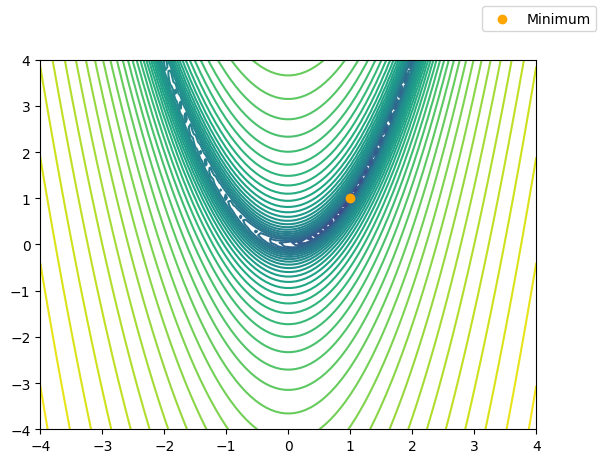

In [3]:
fig = create_contourline_figure(rosenbrock, True)
show_figure(fig)

### Aufgabe - Gradient Abstieg mit numerischen Gradienten (3 Punkte):


Vervollständigen Sie die untenstehenden Funktionen:

* Die Funktion ```numerical_grad2d``` soll den Differenzenquotienten für eine gegebene Funktion ```fn``` an einem Punkt ```xy``` berechnen. Dabei ist ```eps``` die Schrittweite für den Differenzenquotienten.

* Die Funktion ```minimize_numerical``` soll das Minimum der Funktion ```fn``` von einem Startpunkt ```xy``` mit Hilfe des Gradientenabstiegs-Verfahren approximieren. Das Gradientenabstiegs-Verfahren soll die Schrittgröße/Lernrate ```lr``` verwenden.

In [4]:
def numerical_grad2d(fn: Callable, xy: torch.Tensor, eps: float = 1e-4) -> torch.Tensor:
    xy_grad = torch.empty_like(xy)

    # Begin Ihrer Lösung    
    eps_x = torch.zeros_like(xy)
    eps_y = torch.zeros_like(xy)
    
    eps_x[..., 0] = eps
    eps_y[..., 1] = eps

    # x grad
    xy_grad[..., 0] = (fn(xy + eps_x) - fn(xy)) / eps
    # y grad
    xy_grad[..., 1] = (fn(xy + eps_y) - fn(xy)) / eps

    # Ende Ihrer Lösung
    return xy_grad

def minimize_numerical(
    fn: Callable, xy: torch.Tensor, lr: float = 1e-4, steps: int = 1000
) -> torch.Tensor:
    path = torch.empty(size=[steps, 2])
    for idx in range(steps):
        path[idx] = xy.detach().clone()
        xy_grad = numerical_grad2d(fn, xy)        
        # Begin Ihrer Lösung
        step = lr * xy_grad
        xy = xy - step
        # Ende Ihrer Lösung
    return path

Um Ihre Implementierung zu überprüfen, führen Sie bitte die untenstehende Zelle aus. Die Visualisierung der Optimierungsschritte sollte ähnlich wie im folgenden Graphen aussehen:

![](./figures/numerical_path.png)

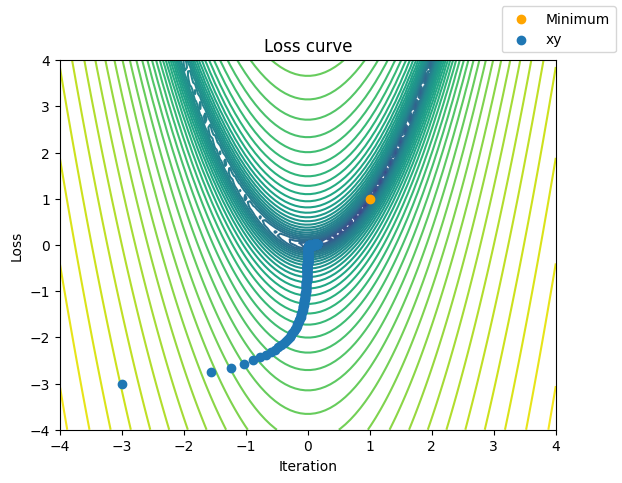

In [5]:
xy = torch.full([2], -3.0)

path = minimize_numerical(rosenbrock, xy)

fig = create_contourline_figure(rosenbrock, True)
fig = scatter_path_in_figure(fig, path, "xy")
show_figure(fig)

### Erläuterung - Automatische Differenzierung in PyTorch

Eine zentrale Funktion von PyTorch ist die automatische Berechnung von Ableitungen. Die Berechnung einer Ableitung in PyTorch kann in drei Schritte aufgeteilt werden:

1. Wir erzeugen Tensoren, die wir als Eingabe für unsere Berechnungen verwenden und für die wir später den Gradient berechnet werden wollen. Bevor wir eine Tensor zum ersten Mal in einer Berechnung verwenden müssen wir PyTorch mitteilen welche, dass wir für diesen Tensor einen Gradienten berechnen wollen. Dafür hat jeder Tensor hat das boolean Attribute [torch.Tensor.requires_grad](https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad.html) welches angibt ob für diesen Tensor der Gradient ausgewertet werden soll. Dieses Attribut kann entweder beim Erstellen des Tensors oder nachträglich wie folgt festgelegt werden:

```python
        th_tensor = torch.ones([2], requires_grad = True) # Beim Erzeugen eines Tensors
        th_tensor.requires_grad_(True) # Nach dem der Tensor schon erzeugt wurde.
```

2. Wir können beliebige mathematische Operationen auf dem Tensor ausführen, um eine Ausgabe zu erhalten. PyTorch wird automatisch einen Berechnungsgraphen erstellen, der die Abhängigkeiten zwischen den Tensoren und den Operationen speichert (dazu mehr auf dem nächsten Übungsblatt).

    * Die Berechnungen dürfen ausschließlich PyTorch Tensoren und Funktionen verwenden. Operatoren ```+,-,*,/,**``` etc., die für den Tensor überladen sind, sind in den PyTorch Funktionen eingeschlossen.  Ebenfalls sind Operationen zwischen skalaren Konstanten und Tensoren wie zum Beispiel ```y = 2.0*x``` sind zulässig.

    * Eine Einschränkung dieser Methode ist, dass wir nur den Gradienten eines skalaren Werts (eine Zahl) berechnen können. Also muss das Ergebnis ein Tensor sein, der nur einen Skalar enthält. d.h. die Form des resultierenden Tensors muss $()$ oder $(1)$ sein.

3. Um den Gradienten der Ausgabe in Bezug auf den Eingangstensor zu berechnen, müssen wir die Methode [torch.Tensor.backward()](https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html) aufrufen, die den Gradienten der Berechnung in dem Attribut [torch.Tensor.grad](https://pytorch.org/docs/stable/generated/torch.Tensor.grad.html) speichert.

Eine weitere Einschränkung ist, dass wir die Methode `backward()` nur einmal pro Berechnungsgraph aufrufen können, es sei denn, wir setzen den Parameter `retain_graph=True`. Andernfalls wird der Graph nach dem Aufruf gelöscht, um Speicherplatz zu sparen.

### Aufgabe - PyTorch Autograd(1 Punkt):

Verwenden Sie die automatische Differenzierung von PyTorch um die Ableitung der Rosenbrock Funktion an der Stelle $(-3,-3)$ zu berechnen und auszugeben.

**Hinweis**: Stellen Sie sicher, dass Ihre Rosenbrockfunktion nur PyTorch Funktionen verwendet und passen Sie Ihre Implementierung ggf. an. Wenn Ihre Implementierung korrekt ist, sollten Sie die Ableitungen $df/dx = 14408$ uns $df/dy=-2400$ im grad-Attribute stehen.

In [6]:
xy = torch.full([2], -3.0)
# Beginn Ihrer Lösung
xy.requires_grad_(True)
rosenbrock(xy).backward()
print(xy.grad)
# Ende Ihrer Lösung

tensor([-14408.,  -2400.])


### Erläuterung - Gradientabstieg in PyTorch

Nachdem wir nun in der Lage sind, mit Hilfe von PyTorch die Ableitung der Rosenbrock-Funktion an einem Punkt $(x,y)$ zu berechnen, sind wir unserem Ziel, ein Minimum der Rosenbrock-Funktion zu finden, einen Schritt näher gekommen. Alles, was wir jetzt noch benötigen, ist ein Algorithmus um ein Update der Position durch Gradientabstieg durchzuführen.

Jeder Optimierungsalgorithmus in PyTorch erbt von der Klasse [torch.optim.Optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.Optimizer) und implementiert die essentiellen Funktionen:

 * Die Methode [torch.optim.Optimizer.step()](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.step.html) aktualisiert die Parameter des Modells, basierend auf den berechneten Gradienten.

 * Die Methode [torch.optim.Optimizer.zero_grad()](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html) setzt alle Gradienten der Parameter des Optimizers auf Null. Dies ist nützlich, um die Gradientenakkumulation zu vermeiden, die bei mehreren Aufrufen von backward() ohne einen Optimierungsschritt auftreten kann. Die zero_grad() Funktion sollte vor jedem Optimierungsschritt aufgerufen werden, um sicherzustellen, dass die Gradienten korrekt berechnet werden.


In der Vorlesung haben wurden vier unterschiedliche Gradient Descent Optimierer vorgestellt, die alle in PyTorch implementiert sind:

 1. [torch.optim.SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) - einfacher (stochastischer) Gradientenabstieg
 2. [torch.optim.Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html) - AdaGrad Algorithmus
 3. [torch.optim.RMSProp](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html) - RMSProp Algorithmus
 4. [torch.optim.Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) - Adam Algorithmus

Der Konstruktor dieser Optimierer erwartet ein Iterable Objekt, das die Parameter enthält, die wir optimieren wollen - also zum Beispiel eine Liste von Tensoren. Zusätzlich akzeptiert jeder Optimierer eine Lernrate als Argument. Hier ist ein Beispiel:
```python
    optimizer = torch.optim.SGD([tensor], lr=0.01)
```

### Aufgabe - Minimum der Rosenbrock-Funktion mit PyTorch (4 Punkte):

* Vervollständigen Sie die Funktion ```minimize``` in der nächsten Codezelle. Die Funktion soll den Funktionswert der Rosenbrock-Funktion an der Stelle ```xy``` auswerten und die Ableitung des Funktionswerts bzgl. des Tensors `xy` bestimmen. Verwenden Sie anschließend den ```optimizer``` um einen Gradientabstieg-Schritt durchzuführen und die Gradienten der Tensoren auf Null zurückzusetzen.

* Verwenden Sie den Optimierer SGD, um das Minimum der Rosenbrockfunktion durch Gradientabstieg zu finden. Die Optimierung soll vom Punkt $(-3,-3)$ starten. Verwenden Sie dabei die Funktion ```minimize```.

In [14]:
def minimize_pytorch(
    xy: torch.Tensor, optimizer: torch.optim.Optimizer, steps: int = 1000
) -> torch.Tensor:
    path = torch.empty(size=[steps, 2])
    for idx in range(steps):
        path[idx] = xy.detach().clone()
        # Beginn Ihrer Lösung
        optimizer.zero_grad()
        rosenbrock(xy).backward()
        optimizer.step()
        # Ende Ihrer Lösung
    return path

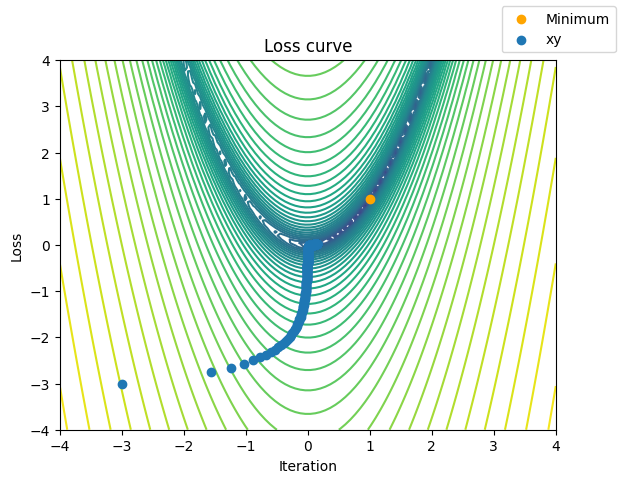

In [15]:
xy = torch.full([2], -3.0, requires_grad=True)

# Begin Ihrer Lösung
optimizer = torch.optim.SGD([xy], lr=1e-4)
path = minimize_pytorch(xy, optimizer)
# Ende Ihrer Lösung


fig = create_contourline_figure(rosenbrock, True)
fig = scatter_path_in_figure(fig, path, "xy")
show_figure(fig)

Wenn Ihre Implementierung korrekt funktioniert sollte die Visualisierung der Optimierungsschritte ähnlich wie die folgenden Figure aussehen:

![](./figures/pytorch_path.png)

## Trapez Klassifizierung mit einem Multilayer Prezeptron

### Erläuterung über nn.Module, nn.Linear und nn.ModuleList

torch.nn.Module ist die Basisklasse für alle neuronalen Netzwerke in PyTorch. Sie definiert die gemeinsame Schnittstelle und Funktionalität für alle Module, wie z.B. Parameterverwaltung, Vorwärts- und Rückwärtsberechnung, Gerätezuordnung und Serialisierung. Ein Modul kann andere Module als Attribute enthalten, um eine hierarchische Struktur zu erzeugen. Ein Modul kann auch benutzerdefinierte Methoden definieren, um seine Logik zu implementieren. torch.nn.Module ist die zentrale Klasse für Deep Learning in PyTorch, da sie die Grundlage für die Erstellung und das Training von komplexen Modellen bietet. In der folgenden Aufgabe werden wir die folgenden Funktionen der Klasse nn.Module verwenden:

* `torch.nn.Module.forward()` - Diese Funktion definiert die Berechnung, die das Modul auf den Eingabedaten ausführt. Sie muss von jeder Unterklasse überschrieben werden.
* `torch.nn.Module.parameters()` - Diese Funktion gibt einen Iterator über alle Parameter des Moduls zurück, die für das Lernen optimiert werden können.
* `torch.nn.Module.apply()` - Diese Funktion wendet eine Funktion rekursiv auf jedes Untermodul (wie von .children() zurückgegeben) sowie auf sich selbst an. Ein typischer Anwendungsfall ist die Initialisierung der Parameter eines Modells (siehe auch torch.nn.init).

In PyTorch besteht ein MLP im wesentlichen aus einer Aneinanderreihung einer Klasse, die die affine Abbildung implementiert und einer Klasse, die eine nicht-lineare Aktivierungsfunktion darstellt. Die erste wesentliche Klasse ist

```python
torch.nn.Linear(in_features, out_features)
```

und implementiert die affine Abbildung $Wx + b$ wobei $W$ die Gewichte, $b$ der Biaswert und $x$ die Eingabe ist. Ihre Argumente `in_features`, `out_features` bestimmen die Dimension des erwarteten Eingabevektors und des Ausgabevektors.

Die zweite Klasse sind die Aktivierungsfunktionen z.B.

```python
    torch.nn.Identity()
    torch.nn.ReLU()
    torch.nn.Tanh()
    torch.nn.Sigmoid()
```

Wichtig ist, dass man sowohl von der Klasse `Linear` als auch der Aktiverungsfunktionen, erst eine Instanz erstellen muss bevor man Sie auf Daten anwendet. Hier ein Beispiel für eine affine Abbildung:

```python
    x = torch.rand(10)
    linear = torch.nn.Linear(10, 1)
    y = linear(x)
```
Es ist zwar aus technischer Sicht möglich, einzeln Instanzen dieser Klassen als Variablen zu erstellen und diese nacheinander auf die Ausgabe der vorherigen Schicht anzuwenden allerdings ist unpraktisch und ineffizient. Stattdessen werden die Schichten von Neuronalen Netzwerken in einer Klasse zusammengefasst, die von `torch.nn.Module` erbt. Im Konstruktor dieser Klasse werden die Instanzen der oben genannten Klassen erzeugt, und in der `forward(self,x)` Funktion werden diese auf die Daten $x$ angewendet. Außerdem müssen die Schichten nicht als einzeln Klassenvariable gespeichert werden sondern können in eine `torch.nn.ModuleList` eingefügt werden. Einer ModuleList kann man, wie bei einer normalen Liste in Python, mit der Funktion `append` weiter Elemente hinzufügen. Beispiel:

```python
    layers = torch.nn.ModuleList()
    layers.append(torch.nn.Linear(a,b))
```

### Aufgabe - Implementierung eines MLPs (2 Punkte)

Erweitern Sie die Klasse `TrapezoidClassifier` so dass sie die Architektur der untenstehenden MLPs statt eines linearen Klassifizierers implementiert. Achten Sie darauf, dass bei einem binären Klassifikationsproblem, der Output der MLPs im Intervall $[0,1]$ liegen muss. Wählen Sie daher eine geeignete Aktivierungsfunktion für die Ausgabeschicht des MLPs.

![](./figures/mlp.png)

In [9]:
class TrapezoidClassifier(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layers = nn.ModuleList()
        # Beginn Iher Lösung
        self.layers.append(nn.Linear(2, 1))  # Ersetzen Sie diese Zeile
        # Ende Ihrer Lösung

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x)
        return x.squeeze()

### Aufgabe - Implementierung der Trainings- und Evaluierungsfunktion (3 Punkte)

* Vervollständigen Sie die Funktion `train_binary`, so dass das Neuronale Netzwerk `model` mit Hilfe des Optimizers `optim` für `num_steps` Iterationen auf den Trainings-Daten ```(train_points, train_labels)``` trainiert wird den `th.nn.BCELoss()` zu minimieren. Zusätzliche soll die Funktion eine Liste der Fehlerwerte, die während des Trainings berechnet wurden, zurückgeben.
    
* Vervollständigen Sie die Funktion `evaluate` so dass Sie die Genauigkeit des Neuronalen Netzwerks `model` auf den Test-Daten ```(test_points, test_labels)``` . Berechnen Sie die Genauigkeit in dem Sie den Netzwerkoutput runden $z_i$ und mit der korrekten Klasse $y_i$ vergleichen:

$$
    \frac{100}{m} \sum_{i = 1}^m \mathbb{I}_i \text{ wobei } \mathbb{I}_i :=
    \begin{cases}
    1 & z_i = y_i \\
    0 & \text{sonst}
    \end{cases}.
$$

Die Funktion soll ebenfalls die gerundenten Netzwerkoutputs zurückgeben.

**Hinweis:** Eine Epoche bezeichnet eine vollständige Iteration über die Element des Datensatzes bzw. über die Minibatches.

In [10]:
def train_binary(
    num_steps: int,
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    train_points: torch.Tensor,
    train_labels: torch.Tensor,
) -> list[float]:
    loss_curve = []
    loss_fn = nn.BCELoss()
    for _ in range(num_steps):
        # Beginn Ihrer Lösung
        # Ende Ihrer Lösung
        loss_curve.append(loss.item())
    return loss_curve

In [11]:
@torch.no_grad()
def evaluate(
    model: torch.nn.Module, test_points: torch.Tensor, test_labels: torch.Tensor
) -> float:
    accuracy = 0.0
    model.eval()
    # Beginn Ihrer Lösung
    # Ende Ihrer Lösung
    model.train()
    return accuracy, predictions

### Aufgabe - Evaluierung  des MLPs (1 Punkt)

Um Ihre Implementierung des MLP sowie der Trainings- und Evaluierungsfunktion zu testen, führen Sie bitte die folgende Codezelle aus. Das MLP sollte eine Genauigkeit von über 90% auf den Testdaten erreichen.

Führen Sie das Experiment fünfmal durch und beschreiben Sie kurz, was Sie dabei beobachten. Insbesondere sollen Sie auf die Kurve der Zielfunktion eingehen und erläutern, warum es Unterschiede zwischen den einzelnen Experimenten gibt.

In [12]:
# Load trainings and test data points
train_points, train_labels = torch.load("./data/trapezoid_train.pt")
test_points, test_labels = torch.load("./data/trapezoid_test.pt")

# Create an instance of the model and optimizer
model = TrapezoidClassifier()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Train the model and visulaize the resulting loss function
loss_curve = train_binary(10000, model, optimizer, train_points, train_labels)
fig = create_losscurve_figure(loss_curve)
show_figure(fig)

# Compute the resulting accuarcy on the test model
accuracy, predictions = evaluate(model, test_points, test_labels)
print(f"Accuarcy of the trained model is {accuracy}")

# Visualize test points and the models prediction
q1, q2, q3, q4 = (1, 1), (4, 2), (5, 5), (0, 4)
fig = create_trapezoid_figure(q1, q2, q3, q4)
fig = scatter_points_and_labels(fig, test_points, predictions, "test")
show_figure(fig)

NameError: name 'loss' is not defined